In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances
from datetime import datetime
from scipy.cluster import hierarchy
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

**Passo 1 - Importar os dados**

In [34]:
Digital_Contact=pd.read_csv("data/Digital_Contact.csv", delimiter=";")
Digital_Contact.set_index('Cust_ID', inplace = True)
Digital_Contact

,Email_Clicks,SM_Comments,App_Clicks,SM_Likes,SM_Shares,SM_Clicks
Cust_ID,,,,,,
4,72,1,7,7,1.0,73
5,15,20,1,35,15.0,16
6,9,7,3,73,19.0,10
9,67,0,2,0,1.0,101
10,38,0,1,9,0.0,56
...,...,...,...,...,...,...
6489,13,14,1,83,22.0,13
6491,17,13,2,22,21.0,7
6492,34,1,2,1,2.0,53


In [35]:
Digital_Contact[Digital_Contact.duplicated()]
#não vejo duplicados, logo não há problemas com linhas repetidas.

,Email_Clicks,SM_Comments,App_Clicks,SM_Likes,SM_Shares,SM_Clicks
Cust_ID,,,,,,


In [36]:
Products=pd.read_excel("data/Products.xlsx")
Products.set_index('Cust_ID', inplace = True)
Products

,Fitness&Gym,Hiking&Running,Last_Purchase,TeamGames,OutdoorActivities,TotalProducts
Cust_ID,,,,,,
4,0,76,2024-02-19,248,37,6
5,0,75,2024-02-17,248,37,6
6,6,69,2024-02-15,215,34,5
9,36,71,2024-02-13,248,35,8
10,8,97,2024-02-15,204,34,5
...,...,...,...,...,...,...
6489,29,36,2024-02-05,53,32,4
6491,38,32,2024-02-01,136,34,5
6492,29,39,2024-02-06,93,34,5


In [37]:
Products[Products.duplicated()]
#vejo duplicados, então vou remover estas transações e seguir com 1 novo DF.

,Fitness&Gym,Hiking&Running,Last_Purchase,TeamGames,OutdoorActivities,TotalProducts
Cust_ID,,,,,,
11,36,71,2024-02-13,248,35,8
91,28,110,2024-02-10,234,31,20
105,22,77,2024-02-18,222,34,5
114,19,104,2024-02-18,215,33,9
132,9,49,2024-02-13,153,38,6
...,...,...,...,...,...,...
6427,35,42,2024-01-07,222,34,5
6449,35,48,2023-12-25,101,32,6
6455,39,58,2024-02-04,242,30,5


In [38]:
duplicadas = Products[Products.duplicated(keep=False)]
duplicadas

,Fitness&Gym,Hiking&Running,Last_Purchase,TeamGames,OutdoorActivities,TotalProducts
Cust_ID,,,,,,
9,36,71,2024-02-13,248,35,8
11,36,71,2024-02-13,248,35,8
86,28,110,2024-02-10,234,31,20
91,28,110,2024-02-10,234,31,20
103,22,77,2024-02-18,222,34,5
...,...,...,...,...,...,...
6455,39,58,2024-02-04,242,30,5
6479,40,46,2023-12-24,182,33,5
6480,27,30,2024-01-27,192,32,5


Demographic=pd.read_csv("Demographic.txt", sep='\t')
Demographic.set_index("Cust_ID", inplace=True)
Demographic

Demographic[Demographic.duplicated()]
#não vejo duplicados, logo não há problemas com linhas repetidas.

**Visualização de Característias básicas dos DF**

In [39]:
Digital_Contact.describe()

,Email_Clicks,SM_Comments,App_Clicks,SM_Likes,SM_Shares,SM_Clicks
count,4000.00000,4000.000000,4000.000000,4000.000000,3961.000000,4000.000000
mean,25.76225,8.247750,19.526500,26.957000,8.355971,30.349250
std,23.65998,8.064963,34.237945,27.742658,8.696192,32.254974
min,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8.00000,1.000000,2.000000,4.000000,1.000000,7.000000
50%,16.00000,4.000000,4.000000,11.000000,2.000000,15.000000
75%,36.00000,15.000000,7.000000,50.000000,16.000000,60.000000
max,86.00000,24.000000,127.000000,88.000000,26.000000,102.000000


In [40]:
Digital_Contact.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4000 entries, 4 to 6496
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Email_Clicks  4000 non-null   int64  
 1   SM_Comments   4000 non-null   int64  
 2   App_Clicks    4000 non-null   int64  
 3   SM_Likes      4000 non-null   int64  
 4   SM_Shares     3961 non-null   float64
 5   SM_Clicks     4000 non-null   int64  
dtypes: float64(1), int64(5)
memory usage: 218.8 KB


Vemos que faltam 9 valores no 'SM_Shares'. Temos de preender de alguma forma, ou alternativamente, apagar essas linhas, umas ve z que são menos de 1%.

In [41]:
Products.describe()

,Fitness&Gym,Hiking&Running,Last_Purchase,TeamGames,OutdoorActivities,TotalProducts
count,4000.000000,4000.000000,4000,4000.000000,4000.000000,4000.000000
mean,32.020250,55.844750,2024-01-30 18:50:02.399999744,176.085000,33.602750,5.329500
min,0.000000,9.000000,2023-10-15 00:00:00,0.000000,28.000000,2.000000
25%,25.000000,38.000000,2024-01-20 00:00:00,121.000000,32.000000,4.000000
50%,31.000000,47.000000,2024-02-01 00:00:00,180.000000,33.000000,5.000000
75%,40.000000,66.000000,2024-02-13 00:00:00,230.000000,35.000000,6.000000
max,123.000000,464.000000,2024-02-29 00:00:00,1203.000000,42.000000,20.000000
std,14.469284,33.119109,NaN,69.964738,1.711483,1.515257


In [42]:
Products.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4000 entries, 4 to 6496
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Fitness&Gym        4000 non-null   int64         
 1   Hiking&Running     4000 non-null   int64         
 2   Last_Purchase      4000 non-null   datetime64[ns]
 3   TeamGames          4000 non-null   int64         
 4   OutdoorActivities  4000 non-null   int64         
 5   TotalProducts      4000 non-null   int64         
dtypes: datetime64[ns](1), int64(5)
memory usage: 218.8 KB


Demographic.describe()

Demographic.info()

In [43]:
numeric = ['Fitness&Gym',	'Hiking&Running'	,'TeamGames',	'OutdoorActivities'	,'TotalProducts']
Products[numeric].skew()

Fitness&Gym          0.346342
Hiking&Running       4.671687
TeamGames            0.740859
OutdoorActivities    0.414896
TotalProducts        1.791119
dtype: float64

O Hiking&Running tem um skew eleveado, o que significa que é pouco simétrico, com cauda à direita. tem outliers

Products.kurt()

In [44]:
Digital_Contact.skew()

Email_Clicks    1.102590
SM_Comments     0.582926
App_Clicks      1.824939
SM_Likes        0.785024
SM_Shares       0.632466
SM_Clicks       0.958356
dtype: float64

In [45]:
Digital_Contact.kurt()

Email_Clicks    0.053571
SM_Comments    -1.171921
App_Clicks      1.900722
SM_Likes       -0.844043
SM_Shares      -1.119464
SM_Clicks      -0.696066
dtype: float64

Demographic.skew()

Demographic.kurt()

**Passo 2- Pré-processadamente dos DF**

No Df Digital_Contact temos valores em branco na SM_Shares, e são valores separados por . Tratarmos com o KNN Imputer.

In [46]:
# Selecione as colunas relevantes para o KNN Imputer
cols_para_imputer = ['SM_Shares', 'SM_Comments', 'SM_Likes', 'SM_Clicks']

# Subset do DataFrame para as colunas relevantes
df_para_imputer = Digital_Contact[cols_para_imputer]
# Configurar o imputer
imputer = KNNImputer(n_neighbors=5, weights='uniform')  # 'distance' também é uma opção
# Aplicar o KNN Imputer
df_imputed = imputer.fit_transform(df_para_imputer)

# Converter a matriz para um DataFrame
df_imputed = pd.DataFrame(df_imputed, columns=cols_para_imputer, index=Digital_Contact.index)

# Atualizar o DataFrame original
Digital_Contact.update(df_imputed)  # Atualiza com os valores preenchidos
# Arredondar os valores para o inteiro mais próximo
Digital_Contact['SM_Shares'] = Digital_Contact['SM_Shares'].round()

# Converter para tipo inteiro (int64)
Digital_Contact['SM_Shares'] = Digital_Contact['SM_Shares'].astype('int64')

No Df Products, criamos
1) Coluna de Total de Gasto,
2) 2) Gasto médio por produto e
3) Trocamos data de última compra por #dias desde da última compra (assumindo 21-04-2024)
4) 4) Removemos os duplicados
5) Deixar cair a coluna 'TotalProducts' porque não dá grande informação.

In [47]:
# Criar a nova coluna "Total_Expensed" com a soma das colunas especificadas
Products['Total_Expensed'] = Products[['Fitness&Gym', 'Hiking&Running', 'TeamGames', 'OutdoorActivities']].sum(axis=1)

In [48]:
Products['Avg_Spent']=Products['Total_Expensed']/Products['TotalProducts']
Products['Avg_Spent'] = np.ceil(Products['Avg_Spent'])  # Arredondar para cima
Products['Avg_Spent']=Products['Avg_Spent'].astype(int)
Products

,Fitness&Gym,Hiking&Running,Last_Purchase,TeamGames,OutdoorActivities,TotalProducts,Total_Expensed,Avg_Spent
Cust_ID,,,,,,,,
4,0,76,2024-02-19,248,37,6,361,61
5,0,75,2024-02-17,248,37,6,360,60
6,6,69,2024-02-15,215,34,5,324,65
9,36,71,2024-02-13,248,35,8,390,49
10,8,97,2024-02-15,204,34,5,343,69
...,...,...,...,...,...,...,...,...
6489,29,36,2024-02-05,53,32,4,150,38
6491,38,32,2024-02-01,136,34,5,240,48
6492,29,39,2024-02-06,93,34,5,195,39


In [49]:
Products['Last_Purchase'] = pd.to_datetime(Products['Last_Purchase'])
today = pd.Timestamp(datetime.today().date())  # ou pd.Timestamp('today')
Products['Days_Since_Last_Purchase'] = (today - Products['Last_Purchase']).dt.days
Products.drop('Last_Purchase', axis=1, inplace=True)
Products

,Fitness&Gym,Hiking&Running,TeamGames,OutdoorActivities,TotalProducts,Total_Expensed,Avg_Spent,Days_Since_Last_Purchase
Cust_ID,,,,,,,,
4,0,76,248,37,6,361,61,67
5,0,75,248,37,6,360,60,69
6,6,69,215,34,5,324,65,71
9,36,71,248,35,8,390,49,73
10,8,97,204,34,5,343,69,71
...,...,...,...,...,...,...,...,...
6489,29,36,53,32,4,150,38,81
6491,38,32,136,34,5,240,48,85
6492,29,39,93,34,5,195,39,80


Produtos_unicos=Products.copy()
# Remover linhas duplicadas no DataFrame Products
Produtos_unicos.drop_duplicates(inplace=True)
Produtos_unicos.drop('TotalProducts', axis=1, inplace=True)
# Exibir o DataFrame para verificar se as duplicatas foram removidas
Produtos_unicos

No Demographic, temos 1) Birmingham mal escrito, 2) Número de dependentes como 2 (é variável binária), 3) Localidade desconhecida, 4) Falta da Coluna "Sexo" 5) Trocar Education Level por numerico e 6) Trocar City Por numérico

1) Correção de Brimingham

Demographic['City']=Demographic['City'].replace('Brimingham', 'Birmingham')
Demographic['City'].value_counts()

2) Correção do # de dependentes

Demographic['dependents'].value_counts()

Demographic.loc[Demographic['dependents'] == 2, 'dependents'] = 1
Demographic['dependents'].value_counts()

3) Localidade desconhecida

# Substituir valores NaN na coluna 'City' por 'Other location'
Demographic['City'].fillna("Other location", inplace=True)
Demographic['City'].value_counts()

4) Criar coluna Sexo com base no nome

# Função para determinar o sexo com base no nome
def determinar_sexo(name):
    if name.startswith('Mr'):
        return 'male'
    else:
        return 'female'

# Aplicar a função à coluna 'name' para criar a nova coluna 'sex'
Demographic['sex'] = Demographic['name'].apply(determinar_sexo)
Demographic['sex'].value_counts()

5. Corrigir Education

# Criar um dicionário para mapear os valores de texto para números
education_mapping = {
    'PHD': 'PhD',
    'PhD':'PhD',
    'Bachelor':'Bachelor',
    'High School':'High School',
    'high school': 'High School',
    'Master':'Master',
    'less than high school':'less than high school',
    }

# Aplicar o mapeamento na coluna 'education_level'
Demographic['education_level'] = Demographic['education_level'].map(education_mapping)
Demographic['education_level'].value_counts()

Demographic.info()

6. Trocar City por numérico

city_mapping = {
    'Other location': 0,
    'Birmingham': 1,
    'London': 2
}

# Aplicar o mapeamento no DataFrame
Demographic['City_number'] = Demographic['City'].map(city_mapping)

sex_mapping = {
    'female': 0,
    'male': 1,
    
}

# Aplicar o mapeamento no DataFrame
Demographic['sex_number'] = Demographic['sex'].map(sex_mapping)

Demographic['age'] = 2024 - Demographic['birth_year']

# Mostrar as primeiras linhas para verificar se está correto
print(Demographic[['birth_year', 'age']].head())
Demographic.drop('birth_year', axis=1, inplace=True)

# Criar um dicionário para mapear os valores de texto para números
education_mapping_2 = {
    'PhD':5,
    'Bachelor':3,
    'High School':2,
    'Master':4,
    'less than high school':1,
    }

# Aplicar o mapeamento na coluna 'education_level'
Demographic['education_level_number'] = Demographic['education_level'].map(education_mapping_2)
Demographic['education_level_number'].value_counts()

stop

**Digital Contact DF**

Identificar o número de Clusters

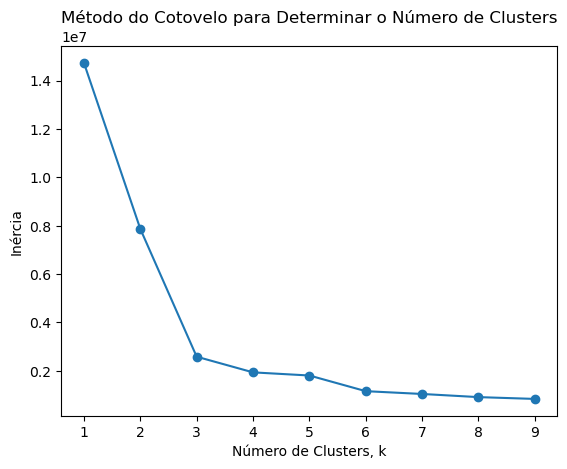

In [50]:
ks_digital = range(1, 10)
inertias_digital = []

for k in ks_digital:
    model_digital = KMeans(n_clusters=k).fit(Digital_Contact)
    inertias_digital.append(model_digital.inertia_)

    
# Plotar a curva de cotovelo
plt.plot(ks_digital, inertias_digital, '-o')
plt.xlabel('Número de Clusters, k')
plt.ylabel('Inércia')
plt.title('Método do Cotovelo para Determinar o Número de Clusters')
plt.xticks(ks_digital)
plt.show()

#pelo grafico, 3 parece ser o número certo de Klusters porque é onde a curva estabiliza

Pelo gráfico, 3 ou 4 parece o número correto de Clusters para o DF Digital.

In [51]:
Digital_Contact_k3= KMeans(n_clusters=3, random_state = 100).fit(Digital_Contact)

In [52]:
Digital_Contact['label_digital']=Digital_Contact_k3.labels_
Digital_Contact #temos 3 klusters, portanto temos valores 0,1 ou 2!

,Email_Clicks,SM_Comments,App_Clicks,SM_Likes,SM_Shares,SM_Clicks,label_digital
Cust_ID,,,,,,,
4,72,1,7,7,1,73,1
5,15,20,1,35,15,16,2
6,9,7,3,73,19,10,2
9,67,0,2,0,1,101,1
10,38,0,1,9,0,56,1
...,...,...,...,...,...,...,...
6489,13,14,1,83,22,13,2
6491,17,13,2,22,21,7,2
6492,34,1,2,1,2,53,1


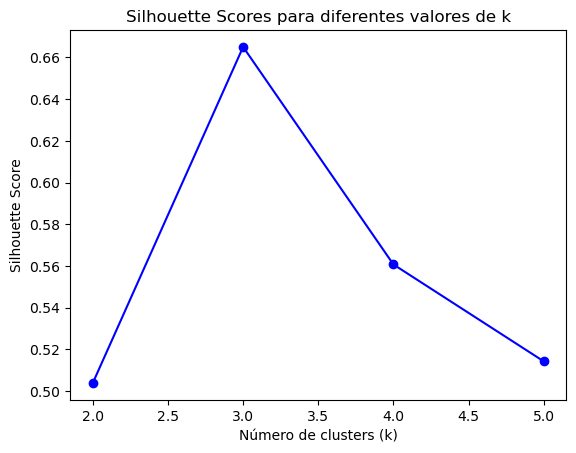

In [53]:
features = Digital_Contact.drop(columns=['label_digital'])  

silhouette_scores_digital = []
k_values_digital = range(2, 6)
for k in k_values_digital:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(features)
    silhouette_avg = silhouette_score(features, cluster_labels)
    silhouette_scores_digital.append(silhouette_avg)

plt.figure()
plt.plot(k_values_digital, silhouette_scores_digital, marker='o', linestyle='-', color='b')
plt.title('Silhouette Scores para diferentes valores de k')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Silhouette Score')
plt.show()

Confirmarmos que são 3 o número ideal de Clusters para o DF Digital_Contact

In [54]:
Digital_Contact.groupby(['label_digital']).mean().transpose()

label_digital,0,1,2
Email_Clicks,18.124122,55.628319,9.682081
SM_Comments,2.010539,0.998391,15.781923
App_Clicks,80.827869,3.501207,2.483973
SM_Likes,3.339578,5.539019,51.545455
SM_Shares,0.983607,1.009654,16.466632
SM_Clicks,10.210773,76.072405,9.521282


In [55]:
descr_digital=Digital_Contact.groupby(['label_digital']).describe().transpose()
descr_digital

label_digital                0            1            2
Email_Clicks count  854.000000  1243.000000  1903.000000
             mean    18.124122    55.628319     9.682081
             std     10.313994    18.741488     5.663851
             min      0.000000    23.000000     0.000000
             25%     10.000000    40.000000     5.000000
             50%     18.000000    55.000000    10.000000
             75%     26.000000    72.000000    15.000000
             max     36.000000    86.000000    19.000000
SM_Comments  count  854.000000  1243.000000  1903.000000
             mean     2.010539     0.998391    15.781923
             std      1.418726     0.815508     5.178136
             min      0.000000     0.000000     7.000000
             25%      1.000000     0.000000    11.000000
             50%      2.000000     1.000000    16.000000
             75%      3.000000     2.000000    20.000000
             max      4.000000     2.000000    24.000000
App_Clicks   count  854.000000  1243.000000  1903.000000
             mean    80.827869     3.501207     2.483973
             std     26.402904     2.274402     1.710557
             min     37.000000     0.000000     0.000000
             25%     58.000000     1.000000     1.000000
             50%     79.000000     4.000000     3.000000
             75%    105.000000     5.000000     4.000000
             max    127.000000     7.000000     5.000000
SM_Likes     count  854.000000  1243.000000  1903.000000
             mean     3.339578     5.539019    51.545455
             std      2.320085     3.509001    21.274826
             min      0.000000     0.000000    15.000000
             25%      1.000000     2.000000    33.000000
             50%      3.000000     5.000000    52.000000
             75%      5.000000     9.000000    70.000000
             max      7.000000    11.000000    88.000000
SM_Shares    count  854.000000  1243.000000  1903.000000
             mean     0.983607     1.009654    16.466632
             std      0.818722     0.822335     5.715643
             min      0.000000     0.000000     7.000000
             25%      0.000000     0.000000    12.000000
             50%      1.000000     1.000000    16.000000
             75%      2.000000     2.000000    21.000000
             max      2.000000     2.000000    26.000000
SM_Clicks    count  854.000000  1243.000000  1903.000000
             mean    10.210773    76.072405     9.521282
             std      6.426066    15.315509     5.775273
             min      0.000000    50.000000     0.000000
             25%      5.000000    63.000000     5.000000
             50%     10.000000    76.000000     9.000000
             75%     16.000000    90.000000    15.000000
             max     21.000000   102.000000    19.000000

In [56]:
dists_digital = euclidean_distances(Digital_Contact_k3.cluster_centers_)
dists_digital

array([[  0.        , 108.30325369,  94.67149048],
       [108.30325369,   0.        ,  95.47359148],
       [ 94.67149048,  95.47359148,   0.        ]])

In [57]:
cluster0_digital=Digital_Contact[Digital_Contact['label_digital']==0]
cluster1_digital=Digital_Contact[Digital_Contact['label_digital']==1]
cluster2_digital=Digital_Contact[Digital_Contact['label_digital']==2]

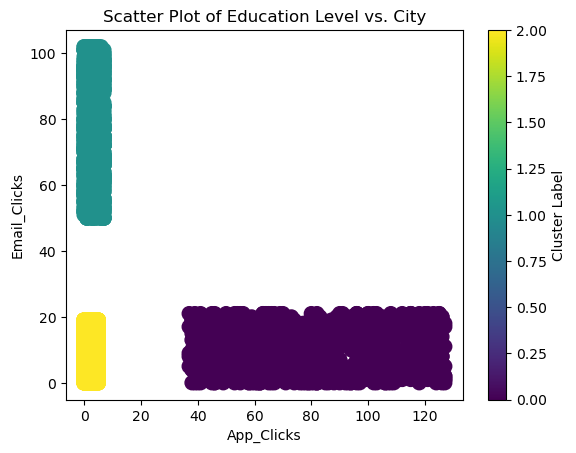

In [58]:
plt.scatter(Digital_Contact['App_Clicks'], Digital_Contact['SM_Clicks'], c=Digital_Contact['label_digital'], s=100)
plt.xlabel('App_Clicks')
plt.ylabel('Email_Clicks')
plt.title('Scatter Plot of Education Level vs. City')
plt.colorbar(label='Cluster Label')  # Adicionar uma barra de cores para indicar os clusters
plt.show()

**Products DF**

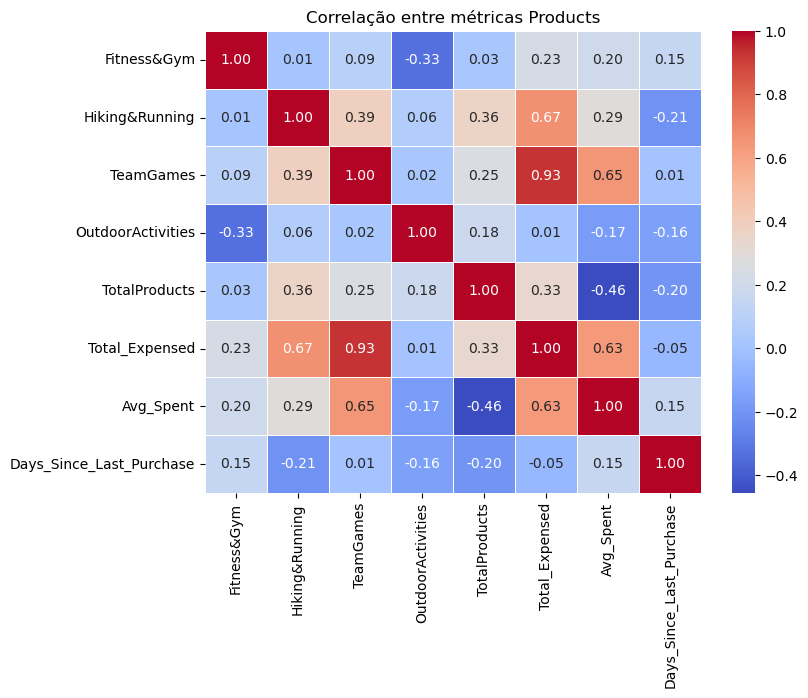

In [59]:
# Calcular a matriz de correlação
correlation_matrix_Products = Products.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix_Products, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlação entre métricas Products')
plt.show() #Vejo correlação mt forte entre Total_Expensed e TeamGames

In [60]:
Products.head()

,Fitness&Gym,Hiking&Running,TeamGames,OutdoorActivities,TotalProducts,Total_Expensed,Avg_Spent,Days_Since_Last_Purchase
Cust_ID,,,,,,,,
4,0,76,248,37,6,361,61,67
5,0,75,248,37,6,360,60,69
6,6,69,215,34,5,324,65,71
9,36,71,248,35,8,390,49,73
10,8,97,204,34,5,343,69,71


### Correr scaling antes do kmeans

In [70]:
scaler = StandardScaler()
Products_scaled = pd.DataFrame(scaler.fit_transform(Products), columns = Products.columns) #applied to all columns because all are numeric
Products_scaled = Products_scaled.drop('Total_Expensed', axis=1)
Products_scaled.head()

,Fitness&Gym,Hiking&Running,TeamGames,OutdoorActivities,TotalProducts,Avg_Spent,Days_Since_Last_Purchase
0,-2.213258,0.608645,1.028003,1.985222,0.442555,0.122862,-1.124793
1,-2.213258,0.578447,1.028003,1.985222,0.442555,0.069922,-1.007720
2,-1.798534,0.397260,0.556278,0.232138,-0.217482,0.334626,-0.890647
3,0.275083,0.457656,1.028003,0.816499,1.762628,-0.512427,-0.773574
4,-1.660293,1.242799,0.399037,0.232138,-0.217482,0.546389,-0.890647


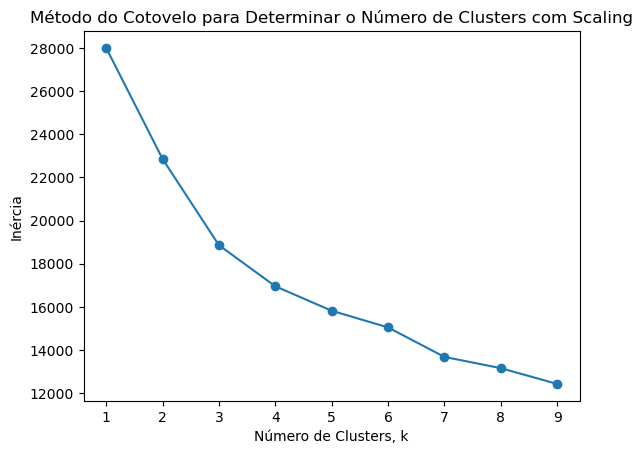

In [71]:
#kmeans com scaling
ks_products = range(1, 10)
inertias_products = []
silhouette_scores_digital_zero = []

for k in ks_products:
    model_products = KMeans(n_clusters=k).fit(Products_scaled)
    inertias_products.append(model_products.inertia_)

    if i > 1:
        silhouette_avg = silhouette_score(features_zero, cluster_labels_zero)
        silhouette_scores_digital_zero.append(silhouette_avg)

    
# Plotar a curva de cotovelo
plt.plot(ks_products, inertias_products, '-o')
plt.xlabel('Número de Clusters, k')
plt.ylabel('Inércia')
plt.title('Método do Cotovelo para Determinar o Número de Clusters com Scaling')
plt.xticks(ks_products)
plt.show()


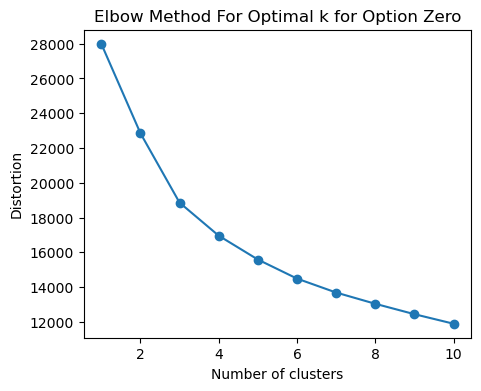

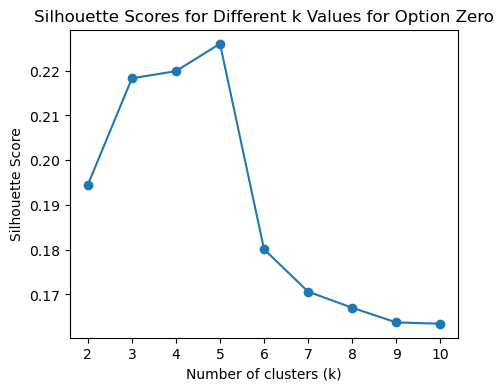

In [72]:
# Calculate distortion for a range of number of cluster
distortions_zero = [] #for elbow method

#for silhouette method
features_zero = Products_scaled
silhouette_scores_digital_zero = []

#calculate relevant measurements for both elbow and silhouette methods
for i in range(1, 11):
    km_zero = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=300, random_state=42) #kmean++ to get a better spreading of the initial centroids
    cluster_labels_zero = km_zero.fit_predict(features_zero)  # Fit and predict simultaneously
    #calculate inertia score
    distortions_zero.append(km_zero.inertia_)

    # Calculate silhouette scores
    if i > 1:
        silhouette_avg = silhouette_score(features_zero, cluster_labels_zero)
        silhouette_scores_digital_zero.append(silhouette_avg)

# Plot the elbow graph
plt.figure(figsize=(5, 4))
plt.plot(range(1, 11), distortions_zero, marker='o')
plt.title('Elbow Method For Optimal k for Option Zero')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

# Plot the silhouette scores, note the range adjustment for x-axis
if len(silhouette_scores_digital_zero) > 0:  # Check if list is not empty
    plt.figure(figsize=(5, 4))
    plt.plot(range(2, 11), silhouette_scores_digital_zero, marker='o')
    plt.title('Silhouette Scores for Different k Values for Option Zero')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.show()

C:\Users\nihon\anaconda3\envs\ds\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\nihon\anaconda3\envs\ds\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\nihon\anaconda3\envs\ds\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\nihon\anaconda3\envs\ds\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\nihon\anaconda3\envs\ds\Lib\subprocess.py", line 1538, in _execute_child


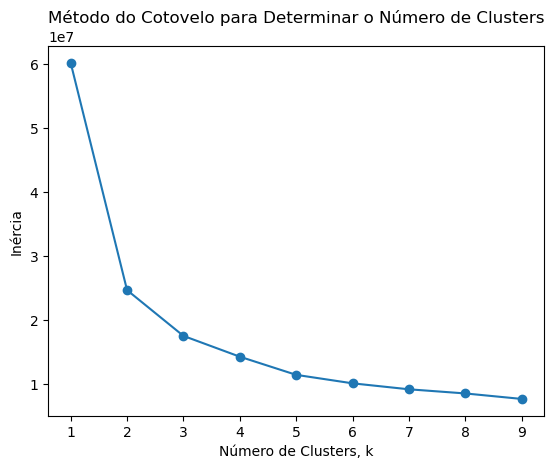

In [25]:
ks_products = range(1, 10)
inertias_products = []

for k in ks_products:
    model_products = KMeans(n_clusters=k).fit(Products)
    inertias_products.append(model_products.inertia_)

    
# Plotar a curva de cotovelo
plt.plot(ks_products, inertias_products, '-o')
plt.xlabel('Número de Clusters, k')
plt.ylabel('Inércia')
plt.title('Método do Cotovelo para Determinar o Número de Clusters')
plt.xticks(ks_products)
plt.show()

#pelo grafico, 3 parece ser o número certo de Klusters porque é onde a curva estabiliza

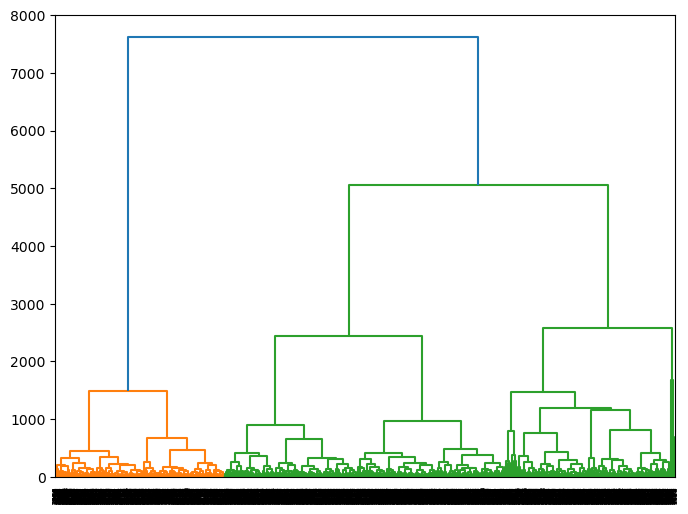

In [27]:
Products = Products.sample(n = 4000, random_state = 100) #o numero é aleatório

# create clusters using the "ward method"
clusters = hierarchy.linkage(Products, method="ward")

# create the dendrogram using the hierarchy.dendrogram() method.
plt.figure(figsize=(8, 6))
dendrogram = hierarchy.dendrogram(clusters) #o resultado confirma o k=2

In [73]:
Products_k2= KMeans(n_clusters=3, random_state = 100).fit(Products_scaled)

In [74]:
Products['label_pro']=Products_k2.labels_
Products

,Fitness&Gym,Hiking&Running,TeamGames,OutdoorActivities,TotalProducts,Total_Expensed,Avg_Spent,Days_Since_Last_Purchase,label_pro
Cust_ID,,,,,,,,,
4,0,76,248,37,6,361,61,67,2
5,0,75,248,37,6,360,60,69,2
6,6,69,215,34,5,324,65,71,2
9,36,71,248,35,8,390,49,73,2
10,8,97,204,34,5,343,69,71,2
...,...,...,...,...,...,...,...,...,...
6489,29,36,53,32,4,150,38,81,0
6491,38,32,136,34,5,240,48,85,0
6492,29,39,93,34,5,195,39,80,0


In [75]:
Products.groupby(['label_pro']).mean().transpose()

label_pro,0,1,2
Fitness&Gym,31.425060,37.766983,26.126642
Hiking&Running,38.914868,54.565561,83.854597
TeamGames,112.703237,221.806477,220.960600
OutdoorActivities,33.421463,32.802528,34.836773
TotalProducts,5.075540,4.616904,6.573171
Total_Expensed,216.464628,346.941548,365.778612
Avg_Spent,44.961631,77.355450,57.963415
Days_Since_Last_Purchase,85.874101,97.703002,73.106004


**Diferenças:**
- more spending in:
- Hiking&Running
- TeamGames, Total_Expensed

In [ ]:
descr_pro=Products.groupby(['label_pro']).describe().transpose()
descr_pro

In [ ]:
# Criar um scaler para normalizar as colunas
scaler = MinMaxScaler()

# Escolher as colunas para normalizar
cols_to_normalize = ['Total_Expensed', 'SM_Likes']  # Adicione as colunas desejadas
merged_df_remover_outlier_k3[cols_to_normalize] = scaler.fit_transform(merged_df_remover_outlier_k3[cols_to_normalize])

# Criar o scatter plot após normalização
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=merged_df_remover_outlier_k3,
    x='Total_Expensed',  # Coluna normalizada
    y='SM_Likes',  # Coluna normalizada
    hue='label',  # Coluna para clusters
    palette='viridis',
    s=50,
    alpha=0.7
)
plt.title('Scatter Plot com Dados Normalizados')
plt.xlabel('Total_Expensed (Normalizado)')
plt.ylabel('SM_Likes (Normalizado)')
plt.show()

In [ ]:
# Criar um scaler para normalizar as colunas
scaler = MinMaxScaler()

# Escolher as colunas para normalizar
cols_to_normalize = ['Total_Expensed', 'Email_Clicks']  # Adicione as colunas desejadas
merged_df_remover_outlier_k3[cols_to_normalize] = scaler.fit_transform(merged_df_remover_outlier_k3[cols_to_normalize])

# Criar o scatter plot após normalização
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=merged_df_remover_outlier_k3,
    x='Total_Expensed',  # Coluna normalizada
    y='Email_Clicks',  # Coluna normalizada
    hue='label',  # Coluna para clusters
    palette='viridis',
    s=50,
    alpha=0.7
)
plt.title('Scatter Plot com Dados Normalizados')
plt.xlabel('Total_Expensed (Normalizado)')
plt.ylabel('Email_Clicks (Normalizado)')
plt.show()

**Demographic DF**

In [ ]:
Demographic_nameless=Demographic.copy() #rescue point

In [ ]:
Demographic_nameless.drop('name', axis=1, inplace=True)
Demographic_nameless

In [ ]:
# Selecionar apenas colunas numéricas
Demographic_nameless = Demographic_nameless.select_dtypes(include=[np.number])

# Calcular a matriz de correlação
correlation_matrix_final = Demographic_nameless.corr()

# Plotar a matriz de correlação
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix_final, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Matriz de Correlação das Variáveis Numéricas')
plt.show()

In [ ]:
ks = range(1, 10)

# Lista para armazenar as inércias
inertias_demographic = []

# Calcular a inércia para cada valor de k
for k in ks:
    model = KMeans(n_clusters=k, random_state=0).fit(Demographic_nameless)
    inertias_demographic.append(model.inertia_)  # Adicionar a inércia à lista

# Plotar a curva do cotovelo
plt.plot(ks, inertias_demographic, '-o')
plt.xlabel('Número de Clusters, k')
plt.ylabel('Inércia')
plt.title('Método do Cotovelo para Determinar o Número de Clusters')
plt.xticks(ks)
plt.show()

In [ ]:
Demographic_nameless = Demographic_nameless.sample(n = 4000, random_state = 100) #o numero é aleatório

# create clusters using the "ward method"
clusters = hierarchy.linkage(Demographic_nameless, method="ward")

# create the dendrogram using the hierarchy.dendrogram() method.
plt.figure(figsize=(8, 6))
dendrogram = hierarchy.dendrogram(clusters) #o resultado confirma o k=2

In [ ]:
Demograhpic_k3 = KMeans(n_clusters=2, random_state = 100).fit(Demographic_nameless)

In [ ]:
Demographic_nameless['label_demo']=Demograhpic_k3.labels_
Demographic_nameless #só temos 2 klusters, portanto temos valores 0 ou 1!

In [ ]:
# Assumindo que você tenha um DataFrame chamado merged_df_k2 para análise de clusters
# Primeiro, vamos extrair as colunas relevantes para o clustering (sem a coluna de cluster se já existir)
features = Demographic_nameless.drop(columns=['label_demo'])  # Mude 'label' para a coluna que indica cluster se existir

# Lista para armazenar a pontuação da Silhouette para diferentes valores de k
silhouette_scores = []

# Variando o número de clusters para encontrar o melhor valor de k
k_values = range(2, 5)  # Testando de 2 a 5 clusters

# Loop para calcular a Silhouette Score para cada valor de k
for k in k_values:
    # Crie o modelo de K-means com o valor de k
    kmeans = KMeans(n_clusters=k, random_state=42)
    
    # Aplique o K-means e obtenha os rótulos dos clusters
    cluster_labels = kmeans.fit_predict(features)
    
    # Calcule a pontuação da Silhouette
    silhouette_avg = silhouette_score(features, cluster_labels)
    
    # Adicione a pontuação ao array de pontuações
    silhouette_scores.append(silhouette_avg)

# Agora vamos plotar a Silhouette Score para diferentes valores de k
plt.figure()
plt.plot(k_values, silhouette_scores, marker='o', linestyle='-', color='b')  # Crie o gráfico
plt.title('Silhouette Scores para diferentes valores de k')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Silhouette Score')
plt.show()  # Exibir o gráfico

O Silhouet confirma claramente que são 2 clusters, porque tme 1 score muito alto.

In [ ]:
Demographic_nameless.groupby(['label_demo']).mean().transpose()

In [ ]:
dists = euclidean_distances(Demograhpic_k3.cluster_centers_)
dists

In [ ]:
cluster0_demo=Demographic_nameless[Demographic_nameless['label_demo']==0]
cluster1_demo=Demographic_nameless[Demographic_nameless['label_demo']==1]

In [ ]:
sns.histplot(cluster0_demo['age'], color='red',label='Age - Cluster 0',bins=20)
sns.histplot(cluster1_demo['age'], color='yellow',label='Age - Cluster 1',bins=20)
plt.legend()

In [ ]:
plt.scatter(Demographic_nameless['age'], Demographic_nameless['education_level'], c=Demographic_nameless['label_demo'], s=100)
plt.xlabel('Education Level')
plt.ylabel('Age')
plt.title('Scatter Plot of Education Level vs. City')
plt.colorbar(label='Cluster Label')  # Adicionar uma barra de cores para indicar os clusters
plt.show()

In [ ]:
Demographic = Demographic.join(Demographic_nameless[['label_demo']], how='left')

In [ ]:
cluster0_demo_original=Demographic[Demographic['label_demo']==0]
cluster1_demo_original=Demographic[Demographic['label_demo']==1]

In [ ]:
print('***Descriptive Summary of Categorical variables***')
print(cluster0_demo_original.describe(include=['O']))

print(' ')
print('***Frequency for each level of education***')
print(round(cluster0_demo_original['education_level'].value_counts()/len(cluster0_demo_original)*100,2))

print(' ')
print('***Mean of Dependents***')
print(cluster0_demo_original['dependents'].mean())

In [ ]:
print('***Descriptive Summary of Categorical variables***')
print(cluster1_demo_original.describe(include=['O']))

print(' ')
print('***Frequency for each level of education***')
print(round(cluster1_demo_original['education_level'].value_counts()/len(cluster1_demo_original)*100,2))

print(' ')
print('***Mean of Dependents***')
print(cluster1_demo_original['dependents'].mean())